In [1]:
source("/secure/projects/HTAPP_MBC/src/init.R")
library(HGNChelper)
library(genefu)

Loading required package: cowplot

Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Loading required package: Matrix
Loading combined annotation: annot
Loading required package: survcomp
Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.5.1"Loading required package: prodlim
Loading required package: mclust
Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: limma
Loading required package: biomaRt
Loading required package: iC10
Loading required package: pamr
Loading required package: cluster
Warning message:
"package 'cluster' was built under R version 3.5.1"Loading required package: iC10TrainingData
Loading required package: AIMS
Loading required package: e1071
Warning message:
"package 'e1071' was built under R version 3.5.1"
Attaching package: 'e1071'

The following object is masked from 'package:Seurat':

    ica

In [2]:
load(file.path(metaDir,"allGenes.Rdata"))

In [3]:
wd=file.path(analysisDir,"00_spatial_probes")
dir.create(wd)
setwd(wd)

Warning message in dir.create(wd):
"'/scratch/projects/HTAPP_MBC//analysis//00_spatial_probes' already exists"

### CODEX/MIBI

In [21]:
cm=fread(file.path(metaDir,"spatial_markers.tsv"))
cm[,assay:=paste0(method,"_",specification),]
cm[,N_type:=.N,by=type]
head(cm)

specification,method,gene,gene_orig,alternative,comment,type_detail,type,assay,N_type
fixed,codex,ACTA2,alpha-SMA,ACTA2,,myofibroblasts,stroma,codex_fixed,29
fixed,codex,BCL2,BCL-2,BCL2,,apoptosis,apoptosis,codex_fixed,1
fixed,codex,CTNNB1,beta-catenin,CTNNB1,,cell-cell adhesion,stroma,codex_fixed,29
fixed,codex,TUBB3,Beta-tubulin 3,TUBB3,,neurons,neuronal,codex_fixed,1
frozen,codex,KIT,CD117,KIT,,"Hematopoetic progenitors, certain cancers",malignant,codex_frozen,3
fixed,mibi,KIT,CD117,KIT,,"Hematopoetic progenitors, certain cancers",malignant,mibi_fixed,3


In [22]:
cat(unique(cm[!gene%in%allGenes]$gene))

KRT6 KRT11 NA TCRD TCRG

In [23]:
cm=cm[gene%in%allGenes]

In [24]:
cm[,priority:=ifelse(assay=="codex_fixed",0,1),]

In [25]:
write.table(cm[,c("gene","type","priority","assay"),],"pre_codex_mibi.tsv",sep="\t",quote=FALSE,row.names = FALSE)

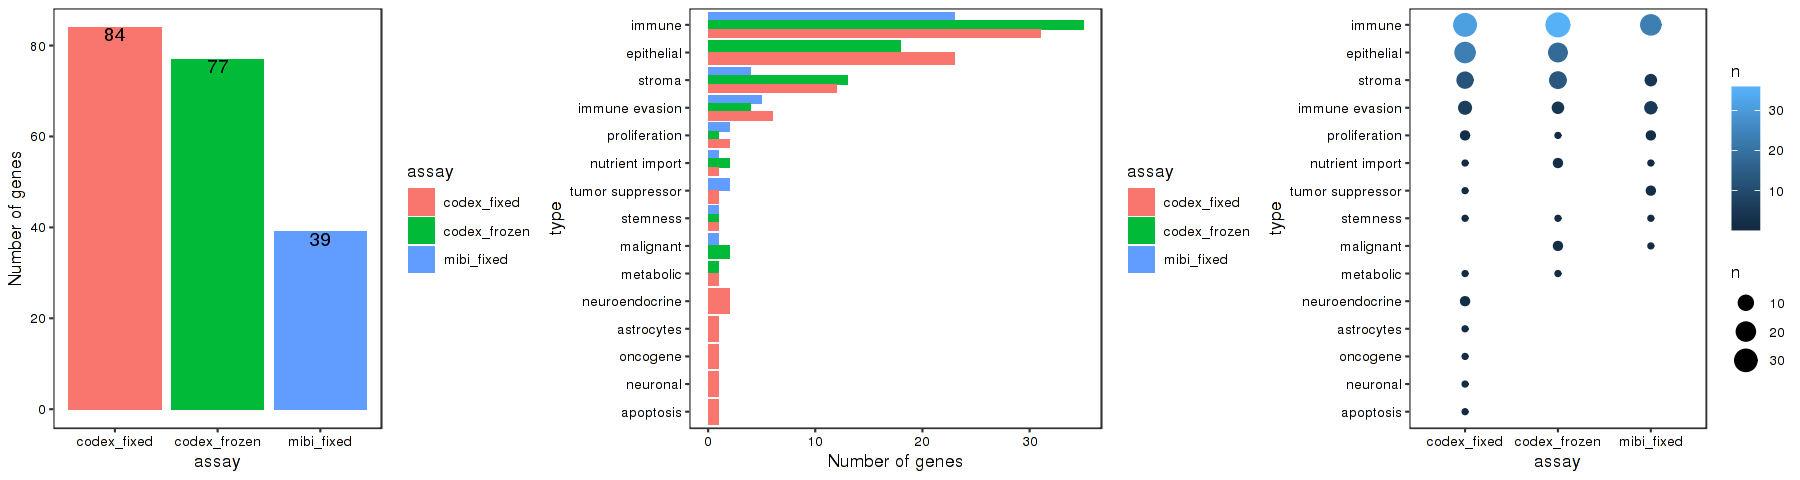

In [26]:
options(repr.plot.width = 15, repr.plot.height = 4)
cm[,type:=factor(type,levels=unique(type[order(N_type)])),]
p1=ggplot(cm,aes(x=assay,fill=assay))+geom_bar()+geom_text(stat='count', aes(label=..count..), vjust=1)+ylab("Number of genes")
p2=ggplot(cm,aes(x=type,fill=assay))+geom_bar(position="dodge")+coord_flip()+ylab("Number of genes")
p3=ggplot(cm,aes(x=assay,y=type))+geom_count(aes(color = ..n.., size = ..n..))
plot_grid(p1,p2,p3,ncol=3,rel_widths = c(3,4,3))

### Interest

In [40]:
int=fread(file.path(metaDir,"interest_genes.csv"))
int[is.na(priority),priority:=0]
head(int)
length(unique(int$gene))

gene,type,priority,assay
ESR1,Receptors,1,interest_mbc
PGR,Receptors,1,interest_mbc
ERBB2,Receptors,1,interest_mbc
AKT1,Resistance,0,interest_mbc
AR,Resistance,1,interest_mbc
ARAF,Resistance,0,interest_mbc


[1] 219

In [41]:
cat(unique(int[!gene%in%allGenes]$gene))

IGFR PUMA BIM CD20 CD138 CD56 MUC18 CD279

In [42]:
int[!gene%in%allGenes,alt:=as.character(checkGeneSymbols(gene)$Suggested.Symbol),by="gene"]
int[!gene%in%allGenes,gene:=ifelse(alt%in%allGenes,alt,gene),by="gene"]
int[!gene%in%allGenes]

Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"Warning message in checkGeneSymbols(gene):
"x contains non-approved gene symbols"

gene,type,priority,assay,alt


In [60]:
cat(unique(int[,as.character(type[order(assay)])]))

B_cells Plasma_cells T_cells macro_mono NK_cells Fibroblasts CAFs Endothelial Epithelial Receptors Resistance Ductal Apoptosis Senescence Proliferation ER signaling Immune checkpoint EMT Basal Myoepithelial Luminal_alveolar (1.1) Luminal_progenitor (1.2) Luminal_hormone_resp. (L2) Mammary stemmness Mammary lineage

In [62]:
int_levels=c("B_cells" ,"Plasma_cells" ,"T_cells", "macro_mono" ,"NK_cells", "Fibroblasts", "CAFs", "Endothelial", "Epithelial", "Receptors", "Resistance" , 
             "Apoptosis", "Senescence", "Proliferation", "ER signaling", "Immune checkpoint", "EMT","Ductal", "Basal", "Myoepithelial", "Luminal_alveolar (1.1)", "Luminal_progenitor (1.2)",
             "Luminal_hormone_resp. (L2)","Mammary stemmness", "Mammary lineage")

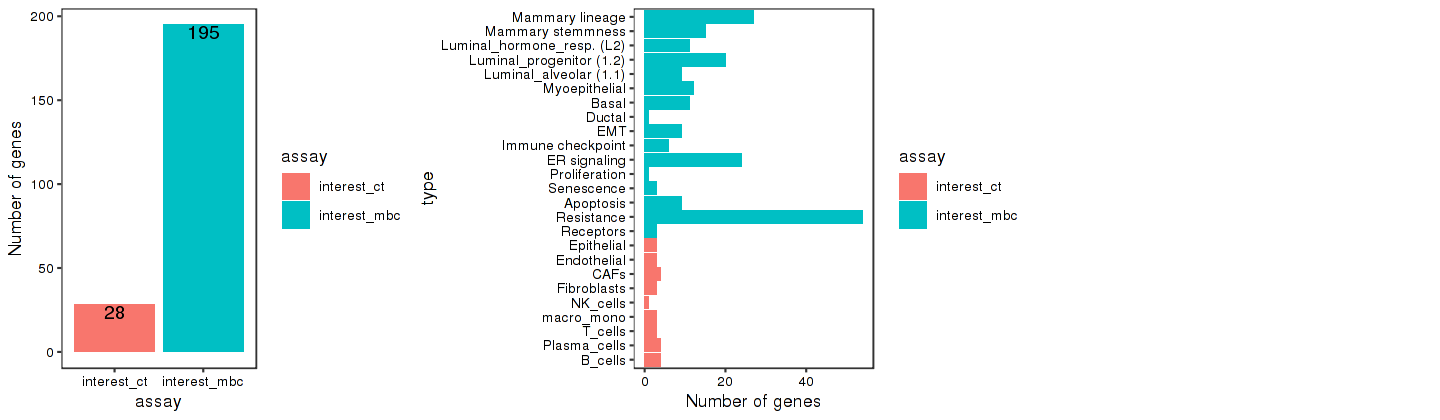

In [64]:
options(repr.plot.width = 12, repr.plot.height = 3.5)
int[,type_N:=.N,by=type]
int_red=unique(int[,c("assay","gene"),])
int[,type:=factor(type,levels=int_levels),]
pl1=ggplot(int_red,aes(x=assay,fill=assay))+geom_bar()+geom_text(stat='count', aes(label=..count..), vjust=1)+ylab("Number of genes")
pl2=ggplot(int,aes(x=type,fill=assay))+geom_bar()+coord_flip()+ylab("Number of genes")
plot_grid(pl1,pl2,ncol=3,rel_widths = c(1,1.5))

In [65]:
write.table(int[,c("gene","type","priority","assay"),],"pre_interest.tsv",sep="\t",quote=F,row.names = FALSE)

#### pam50

In [23]:
pam50_cen=as.data.table(pam50$centroids,keep.rownames = "gene")
pam50_cen[,type:=c("Basal","Her2","LumA","LumB","Normal")[which.max(c(Basal,Her2,LumA,LumB,Normal))],by=1:nrow(pam50_cen)]

In [24]:
pam50_cen_long=melt(pam50_cen,id.vars = c("gene","type"))
pam50_cen_long[,gene:=factor(gene,levels=unique(gene[order(type)])),]

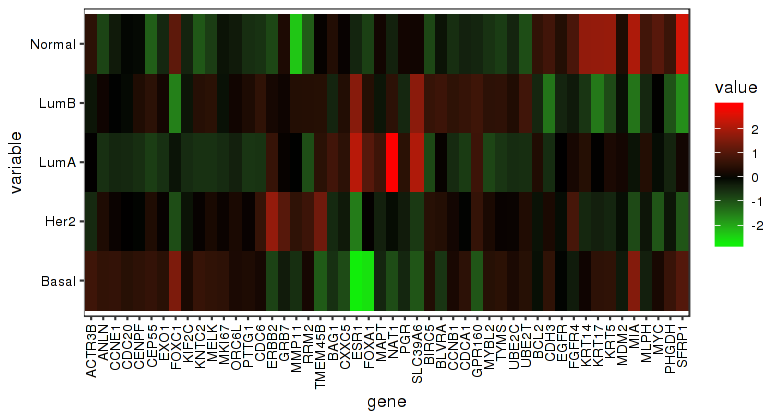

In [26]:
options(repr.plot.width = 6.5, repr.plot.height = 3.5)
ggplot(pam50_cen_long,aes(x=gene,y=variable,fill=value))+geom_tile()+scale_fill_gradient2(high = "red",mid="black",low="green")+theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))